### Content

This dataset contains Measured/Calculated wave parameters. Measured and derived wave data from data collected by oceanographic wave measuring buoys anchored at Mooloolaba. Coverage period: 30 months.

### Acknowledgements

This data comes from Queensland Government Data - https://data.qld.gov.au/dataset.

* Date/Time: Date
* Hs: Significant wave height, an average of the highest third of the waves in a record
* Hmax: The maximum wave height in the record
* Tz: The zero upcrossing wave period
* Tp: The peak energy wave period
* Peak Direction: Direction (related to true north) from which the peak period waves are coming from
* SST: Approximation of sea surface temperature

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as K
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize, signal, interpolate
print(tf.__version__)

2.0.0-beta1


In [2]:
df = pd.read_csv('Coastal Data System - Waves (Mooloolaba) 01-2017 to 06 - 2019.csv')
df.head()
# df.info

,Date/Time,Hs,Hmax,Tz,Tp,Peak Direction,SST
0,01/01/2017 00:00,-99.900,-99.90,-99.900,-99.900,-99.9,-99.90
1,01/01/2017 00:30,0.875,1.39,4.421,4.506,-99.9,-99.90
2,01/01/2017 01:00,0.763,1.15,4.520,5.513,49.0,25.65
3,01/01/2017 01:30,0.770,1.41,4.582,5.647,75.0,25.50
4,01/01/2017 02:00,0.747,1.16,4.515,5.083,91.0,25.45


In [3]:
var = np.array(df['SST'])
# plt.plot(var)
time = np.arange(len(var))
var[np.where(var<-90)] = np.nan
# sst = np.ma.masked_where(var < -90, var)
# print(~np.isnan(var),var[-3:])
try:
    sst = interpolate.interp1d(time[~np.isnan(var)], var[~np.isnan(var)], time)
except:
    print(1)
    for _ in range(len(var)):
        # print(np.isnan(var[_]))
        if np.isnan(var[_]):
            # print(_)
            if _ < 20:
                # print(_)
                var[_] = np.nanmean(var[:_+20])
            else:
                var[_] = np.nanmean(var[_-20:_+20])
    
    sst = var




1


/usr/local/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:438: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if kind in ['zero', 'slinear', 'quadratic', 'cubic']:
/usr/local/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:445: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif kind not in ('linear', 'nearest', 'previous', 'next'):


### define seasonality


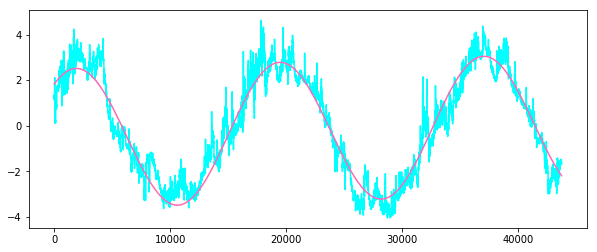

In [4]:
def linf(x,a,b):
    return a * x + b
paramsl,params_covariance = optimize.curve_fit(linf, np.arange(len(var)), sst , maxfev = 10000)
baseline = linf(np.arange(len(var)), paramsl[0], paramsl[1]) ;

def func(x, a, b, c, d):
    return a * (np.cos(b * x * np.pi/(360*24*2) + c)) + d

# Para = leastsq(error, p0, args=(x, y), maxfev=500000)
params,params_covariance = optimize.curve_fit(func, np.arange(len(var)), sst, maxfev = 10000)


plt.figure(figsize=(10,4))
plt.plot(np.arange(len(var)),var - baseline,color='#00FFFF')
# plt.plot(np.arange(len(var)),baseline,color='#00FFFF')
plt.plot(func(np.arange(len(var)), params[0], params[1], params[2], params[3])-baseline,
         color='#FF69B4')

35000


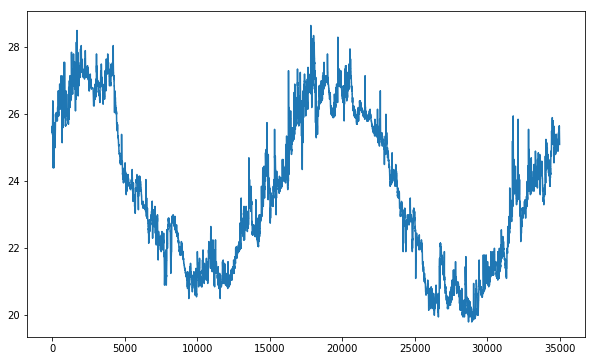

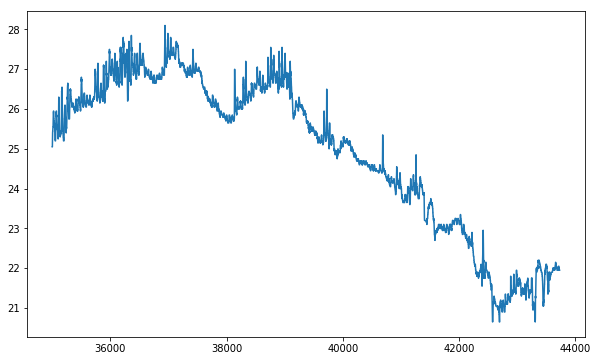

In [5]:
split_time = round(len(var) * 0.8 / 1000) * 1000
print(split_time)
var[np.where(var < -90)] = np.nan
sst = var

time_train = time[:split_time]
x_train = sst[:split_time]
time_valid = time[split_time:]
x_valid = sst[split_time:]
plt.figure(figsize=(10, 6))
plt.plot(time_train, x_train)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(time_valid, x_valid)
plt.show()

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [ ]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(100, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9), metrics=['accuracy'])
# model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=0.2, momentum=0.9), metrics=['accuracy'])
history = model.fit(dataset,epochs=100,verbose=0)

In [ ]:
forecast = []
for time in range(len(sst) - window_size):
  forecast.append(model.predict(sst[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plt.plot(time_valid, x_valid, color='#00FFFF')
plt.plot(time_valid, results, color='#FF69B4')

In [ ]:

epochs=range(len(acc)) # Get number of epochs

acc=history.history['accuracy']
loss=history.history['loss']


plt.plot(epochs, loss, 'r', "Training Accuracy")
plt.title('Training and validation accuracy')
plt.ylim([0.01,0.04])
plt.figure()
# print(loss)

In [ ]:
plt.figure(figsize=(10,4))
remove_ssn = sst - linf(np.arange(len(var)), paramsl[0], paramsl[1])
         - func(np.arange(len(var)), params[0], params[1], params[2], params[3])
plt.plot(remove_ssn, color='#FF69B4')